# Финальный проект - SQL

### Описание проекта

Коронавирус застал мир врасплох, изменив привычный порядок вещей. В свободное время жители городов больше не выходят на улицу, не посещают кафе и торговые центры. Зато стало больше времени для книг. Это заметили стартаперы — и бросились создавать приложения для тех, кто любит читать.

Наша компания решила быть на волне и купила крупный сервис для чтения книг по подписке. Задача  аналитика — проанализировать базу данных. В ней — информация о книгах, издательствах, авторах, а также пользовательские обзоры книг. Эти данные помогут сформулировать ценностное предложение для нового продукта.

### ER-Диаграмма базы данных

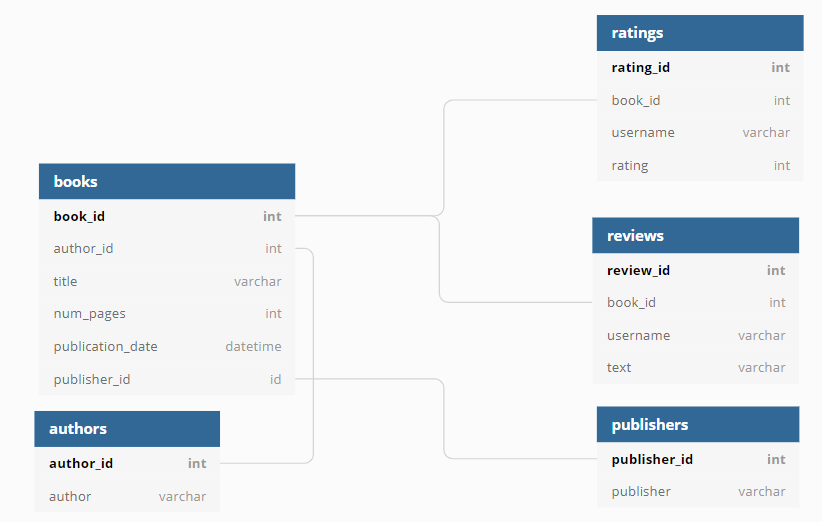

### Задачи

- Рассчитать, сколько книг вышло после 1 января 2000 года;
- Для каждой книги рассчитать количество обзоров и среднюю оценку;
- Определить издательство, которое выпустило наибольшее число книг толще 50 страниц — так мы исключим из анализа брошюры;
- Определить автора с самой высокой средней оценкой книг — учитывать только книги с 50 и более оценками;
- Посчитать среднее количество обзоров от пользователей, которые поставили больше 50 оценок.

### Описание данных

**Таблица `books`**

Содержит данные о книгах:

- `book_id` — идентификатор книги;
- `author_id` — идентификатор автора;
- `title` — название книги;
- `num_pages` — количество страниц;
- `publication_date` — дата публикации книги;
- `publisher_id` — идентификатор издателя.

**Таблица `authors`**

Содержит данные об авторах:

- `author_id` — идентификатор автора;
- `author` — имя автора.

**Таблица `publishers`**

Содержит данные об издательствах:

- `publisher_id` — идентификатор издательства;
- `publisher` — название издательства;

**Таблица `ratings`**

Содержит данные о пользовательских оценках книг:

- `rating_id` — идентификатор оценки;
- `book_id` — идентификатор книги;
- `username` — имя пользователя, оставившего оценку;
- `rating` — оценка книги.

**Таблица `reviews`**

Содержит данные о пользовательских обзорах на книги:

- `review_id` — идентификатор обзора;
- `book_id` — идентификатор книги;
- `username` — имя пользователя, написавшего обзор;
- `text` — текст обзора.

### Подключение к базе данных 

In [1]:
#импорт необходимых библиотек
import pandas as pd
from sqlalchemy import create_engine 

In [2]:
# устанавливаем параметры
db_config = []
with open('params_db.txt') as f:
    for line in f:
        db_config.append(line.strip())

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config[0], # имя пользователя
    db_config[1], # пароль
    db_config[2], # название сервера
    db_config[3], # порт подключения
    db_config[4], # название базы данных
)
# сохраняем коннектор
engine = create_engine(connection_string, connect_args={'sslmode':'require'}) 

Проверим, всё ли правильно работает:

In [3]:
query = '''
SELECT *
FROM books
LIMIT 5;
'''

sample_df = pd.io.sql.read_sql(query, con = engine) 
sample_df

,book_id,author_id,title,num_pages,publication_date,publisher_id
0,1,546,'Salem's Lot,594,2005-11-01,93
1,2,465,1 000 Places to See Before You Die,992,2003-05-22,336
2,3,407,13 Little Blue Envelopes (Little Blue Envelope...,322,2010-12-21,135
3,4,82,1491: New Revelations of the Americas Before C...,541,2006-10-10,309
4,5,125,1776,386,2006-07-04,268


**Всё работает!**

## Первая задача

**Рассчитать, сколько книг вышло после 1 января 2000 года**

In [4]:
query = '''
SELECT COUNT(book_id)
FROM books 
WHERE publication_date > '2000-01-01'
'''

query_1 = pd.io.sql.read_sql(query, con = engine) 

In [5]:
query_1

,count
0,819


In [6]:
query = '''
SELECT COUNT(book_id)
FROM books 
WHERE publication_date > '1999-12-31'
'''

query_1 = pd.io.sql.read_sql(query, con = engine) 

In [7]:
query_1

,count
0,821


**Выводы**

* Решение 1 - начиная со 2 января 2000 года всего вышло 819 книг
* Решение 2 - начиная со 1 января 2000 года всего вышла 821 книга

## Вторая задача

**Для каждой книги рассчитать количество обзоров и среднюю оценку**

In [8]:
query = '''
WITH temp_1 AS (
SELECT book_id,
       ROUND(AVG(rating), 2) AS avg_rating
FROM ratings 
GROUP BY book_id),

temp_2 AS (
SELECT book_id,
       COUNT(review_id) AS reviews_cnt
FROM reviews 
GROUP BY book_id)

SELECT t1.book_id,
       t1.avg_rating,
       t2.reviews_cnt
FROM temp_1 AS t1
LEFT JOIN temp_2 AS t2 ON t1.book_id=t2.book_id
'''

query_2 = pd.io.sql.read_sql(query, con = engine)

In [9]:
query_2

,book_id,avg_rating,reviews_cnt
0,1,3.67,2.0
1,2,2.50,1.0
2,3,4.67,3.0
3,4,4.50,2.0
4,5,4.00,4.0
...,...,...,...
995,996,3.67,3.0
996,997,3.40,3.0
997,998,3.20,4.0
998,999,4.50,2.0


Так как таблицы разных размеров, то для обзоров появятся пропуски:

In [10]:
query_2[query_2['reviews_cnt'].isna()]

,book_id,avg_rating,reviews_cnt
82,83,3.67,NaN
190,191,4.00,NaN
220,221,4.00,NaN
386,387,4.00,NaN
671,672,5.00,NaN
807,808,3.00,NaN


**Выводы**

Мы успешно вывели для каждой книги количество обзоров и среднюю оценку 🐱‍💻

## Задача 3

**Определить издательство, которое выпустило наибольшее число книг толще 50 страниц**

In [11]:
query = '''
SELECT publisher
FROM publishers
WHERE publisher_id = (SELECT publisher_id
                             FROM books 
                             WHERE num_pages > 50
                             GROUP BY publisher_id
                             ORDER BY COUNT(book_id) DESC
                             LIMIT 1)
   
       
'''

query_3 = pd.io.sql.read_sql(query, con = engine) 

In [12]:
query_3

,publisher
0,Penguin Books


**Выводы**

Искомым издательством оказалось `Penguin Books`

## Задача 4

**Определить автора с самой высокой средней оценкой книг — учитывать только книги с 50 и более оценками**

In [13]:
query = '''
SELECT author,
       ROUND(AVG(rating), 2) as avg_rating
FROM authors AS a
INNER JOIN books AS b ON b.author_id=a.author_id
INNER JOIN ratings AS r ON r.book_id=b.book_id
WHERE b.book_id IN (SELECT  book_id
                            FROM ratings
                            GROUP BY book_id
                            HAVING COUNT(rating) > 50)
GROUP BY author
ORDER BY AVG(rating) DESC
LIMIT 1
'''

query_4 = pd.io.sql.read_sql(query, con = engine) 

In [14]:
query_4

,author,avg_rating
0,J.K. Rowling/Mary GrandPré,4.29


**Выводы**

Автором с самой высокой средней оценкой книг оказалась `Джоан Роулинг`. Средняя оценка её книг (у которых более 50 отзывов) равна 4.29. 

## Задача 5

**Посчитать среднее количество обзоров от пользователей, которые поставили больше 50 оценок**

In [15]:
query = '''
WITH temp AS 
   (SELECT username,
           COUNT(review_id) AS review_cnt
    FROM reviews
    WHERE username IN (SELECT username
                              FROM ratings
                              GROUP BY username
                              HAVING COUNT(rating) > 50)
    GROUP BY username)
    
SELECT ROUND(AVG(review_cnt), 2)
FROM temp
'''

query_5 = pd.io.sql.read_sql(query, con = engine) 

In [16]:
query_5

,round
0,24.33


**Выводы**

Среднее количество обзоров от пользователей, которые поставили больше 50 оценок равно 24,33